## Inverse Problem

This notebook is a simple example of how to solve an inverse problem using at3d. It assumes that we have run the 'SimulateRadiances' notebook and saved the result.

In [1]:
#imports
import at3d
import numpy as np
import xarray as xr
from collections import OrderedDict
import pylab as py
import warnings
np.random.seed(1)


### Load Measurements

Here we load the synthetic measurements and also all of the inputs to the solver. We will use several of these inputs to perform 'inverse crimes' whereby we fix some aspects of the problem perfectly as in the forward simulation. When using real world measurements no such short cuts are necessary.

* First, we have to look at the measurements and select a region of interest and define our `rte_grid`. 
* Then we have to model the sensor sub-pixel geometry.
* We need to analyze whether the grid and sensor geometry are consistent. The SpaceCarver is useful for this. If not then we may need to change resolution of `rte_grid` to match the resolution of the measurements etc.
* We need to decide how to represent the surface, which is currently fixed.
* We need to decide how to represent the atmosphere.
    * What scattering species are we modelling? What are their optical models? 
    * Which quantities will be unknowns and which are fixed?
    * What will be the abstract state that we will reconstruct? For this we need to set the mapping between the abstract state and the RTE solver.
* Now that we are organized we need to initialize our state vector of unknowns. The method for this initialization may itself be quite involved as starting nearer the answer is better. This typically goes hand in hand with the selection of any fixed variables.
* Lastly we perform the optimization.

In this tutorial we will reconstruct only the `extinction` and we will use forward quantities from the ground truth synthetic measurements for simplicity.

### Checks

In [2]:
sensors, solvers, rte_grid = at3d.util.load_forward_model('./SimulateRadiancesSmallRico45DegreeSun.nc')

In [3]:
# Perform some cloud masking using a single fixed threshold based on the observation that 
# everywhere else will be very dark.
sensor_list = []
for sensor in sensors['MSPI']['sensor_list']:
    copied = sensor.copy(deep=True)
    weights = np.zeros(sensor.sizes['nrays'])
    ray_mask =np.zeros(sensor.sizes['nrays'], dtype=int)
    
    ray_mask_pixel = np.zeros(sensor.npixels.size, dtype=int)
    
    # I have not optimized this threshold whatsoever.
    # Feel free to experiment with the cloud mask threshold. 
    # You can compare the observations
    # with a visualization of the initial_state to evaluate the mask.
    # or look at at3d.space_carve.SpaceCarver.project
    ray_mask_pixel[np.where(sensor.I.data > 0*2e-3)] = 1
    copied['weights'] = ('nrays',sensor.I.data)
    copied['cloud_mask'] = ('nrays', ray_mask_pixel[sensor.pixel_index.data])
    sensor_list.append(copied)

space_carver = at3d.space_carve.SpaceCarver(rte_grid, bcflag=3)
carved_volume = space_carver.carve(sensor_list, agreement=(0.0, 1.0), linear_mode=False)

# remove cloud mask values at outer boundaries to prevent interaction with open boundary conditions.
carved_volume.mask[0] = carved_volume.mask[-1] =carved_volume.mask[:,0] =carved_volume.mask[:,-1] = 0.0
        

In [4]:

# make forward_sensors which will hold synthetic measurements from the evaluation of the forward model.
forward_sensors = sensors.make_forward_sensors()

# add an uncertainty model to the observations.
uncertainty = at3d.uncertainties.NullUncertainty('L2',1e8)#at3d.uncertainties.TandemStereoCamera('L2', camera_to_camera_calibration_uncertainty=0.0,
              #                                      absolute_calibration_uncertainty=0.0)#at3d.uncertainties.RadiometricUncertainty('L2',1e-5, 1e-3)
sensors.add_uncertainty_model('MSPI', uncertainty)

# prepare all of the static inputs to the solver just copy pasted from forward model
surfaces = OrderedDict()
numerical_parameters = OrderedDict()
sources = OrderedDict()
num_stokes = OrderedDict()
background_optical_scatterers = OrderedDict()
for key in forward_sensors.get_unique_solvers():
    surfaces[key] = solvers[key].surface
    numerical_params = solvers[key].numerical_params
    #numerical_params['num_mu_bins'] = 2
    #numerical_params['num_phi_bins'] = 4
    numerical_parameters[key] = numerical_params
    sources[key] = solvers[key].source
    num_stokes[key] = solvers[key]._nstokes
    background_optical_scatterers[key] = {'rayleigh': solvers[key].medium['rayleigh']}

mie_mono_tables = OrderedDict()
for wavelength in [.66]:
    mie_mono_tables[wavelength] = at3d.mie.get_mono_table(
        'Water',(wavelength,wavelength),
        max_integration_radius=65.0,
        minimum_effective_radius=0.1,
        relative_dir='../mie_tables',
        verbose=False
    )

optical_property_generator = at3d.medium.OpticalPropertyGenerator(
    'cloud', 
    mie_mono_tables,
    at3d.size_distribution.gamma,
    density_normalization='geometric_extinction',
    reff=np.linspace(.1,30.0,30),
    veff=np.linspace(0.03,0.2,9),
)

In [5]:
# set the generator for the unknown scatterer using ground truth optical properties
# and unknown extinction.
# GridToOpticalProperties holds the fixed optical properties and forms a full set of optical properties
# when it is called with extinction as the argument.

optical_properties = solvers[0.66].medium['cloud'].copy(deep=True)
optical_properties = optical_properties.drop_vars('extinction')

true_geo_extinct = 3.0*solvers[0.66].medium['cloud'].density.data/(2.0*997.0* solvers[0.66].medium['cloud'].reff.data*1e-6)


%matplotlib inline
def plot(optimizer):
    py.figure()
    fig, axs = py.subplots(1, 2)
    axs[0].plot(solvers_reconstruct[0.66].medium['cloud'].density.data.ravel(), 
            true_geo_extinct.ravel(),'x')
    axs[0].plot([0,130],[0,130])
    axs[1].plot(solvers_reconstruct[0.66].medium['cloud'].reff.data.ravel(), 
            solvers[0.66].medium['cloud'].reff.data.ravel(),'x')
    axs[1].plot([0,30],[0,30])
    axs[1].axvline(x = np.nanmean(solvers[0.66].medium['cloud'].reff.data.ravel()), color = 'r', linestyle='--')
    py.show()
    return {'None': None}
callback = at3d.callback.CallbackFn(plot)


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.633  0.385E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     2  -1.280  0.391E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     3  -1.525  0.383E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     4  -1.694  0.296E+00    32009    39.74  0.155   [Radiance 0.660 micron]
     5  -1.984  0.189E+00    32196    40.98  0.160   [Radiance 0.660 micron]
     6  -2.051  0.119E+00    32973    45.61  0.178   [Radiance 0.660 micron]
     7  -2.097  0.889E-01    33842    50.41  0.197   [Radiance 0.660 micron]
     8  -2.239  0.739E-01    34684    54.71  0.214   [Radiance 0.660 micron]
     9  -2.305  0.598E-01    36255    62.35  0.244   [Radiance 0.660 micron]
    10  -2.350  0.509E-01    37830    69.60  0.272   [Radiance 0.660 micron]
    11  -2.438  0.452E-01    39284    75.70  0.296   [Radiance 0.660 micron]
    12  -2.490  0.396E-01    41301    83.77  0.327   [Radiance 0.660 micron]
  

<Figure size 640x480 with 0 Axes>

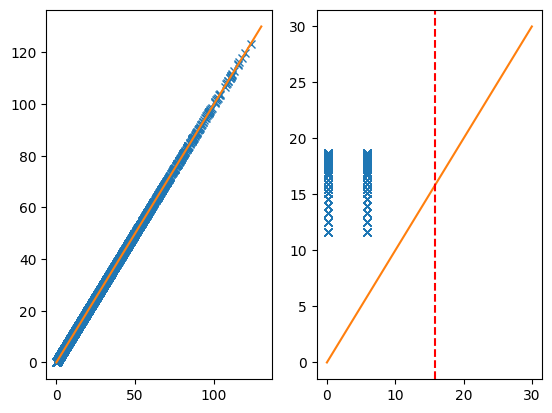

748.0290928071257
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.632  0.377E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     2  -1.280  0.383E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     3  -1.527  0.374E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     4  -1.698  0.290E+00    32009    39.74  0.155   [Radiance 0.660 micron]
     5  -1.991  0.183E+00    32196    40.98  0.160   [Radiance 0.660 micron]
     6  -2.060  0.117E+00    32928    45.40  0.177   [Radiance 0.660 micron]
     7  -2.105  0.870E-01    33802    50.20  0.196   [Radiance 0.660 micron]
     8  -2.244  0.724E-01    34632    54.45  0.213   [Radiance 0.660 micron]
     9  -2.321  0.588E-01    36118    61.73  0.241   [Radiance 0.660 micron]
    10  -2.359  0.498E-01    37721    69.12  0.270   [Radiance 0.660 micron]
    11  -2.462  0.443E-01    39136    75.20  0.294   [Radiance 0.660 micron]
    12  -2.492  0.384E-01    41286    83.78  0.327   [Radianc

<Figure size 640x480 with 0 Axes>

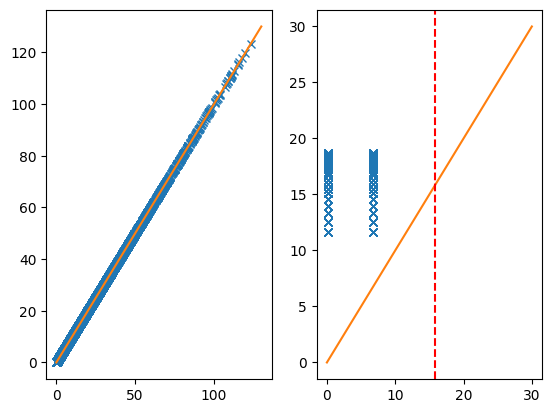

495.7427008679175
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.632  0.370E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     2  -1.279  0.376E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     3  -1.529  0.367E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     4  -1.701  0.286E+00    32008    39.74  0.155   [Radiance 0.660 micron]
     5  -1.998  0.183E+00    32195    40.98  0.160   [Radiance 0.660 micron]
     6  -2.066  0.115E+00    32920    45.37  0.177   [Radiance 0.660 micron]
     7  -2.111  0.857E-01    33762    50.01  0.195   [Radiance 0.660 micron]
     8  -2.252  0.714E-01    34596    54.32  0.212   [Radiance 0.660 micron]
     9  -2.331  0.579E-01    36050    61.42  0.240   [Radiance 0.660 micron]
    10  -2.369  0.489E-01    37659    68.88  0.269   [Radiance 0.660 micron]
    11  -2.474  0.435E-01    39044    74.89  0.293   [Radiance 0.660 micron]
    12  -2.499  0.376E-01    41220    83.59  0.327   [Radianc

<Figure size 640x480 with 0 Axes>

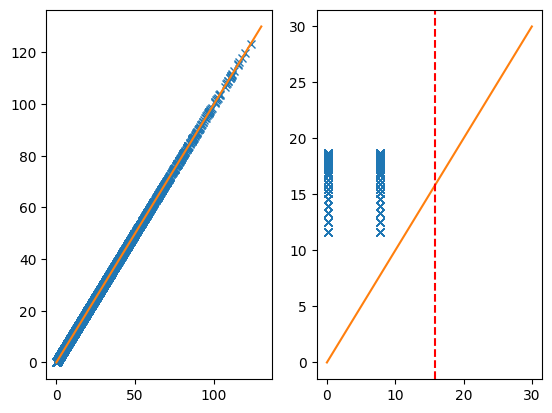

329.3702782056407
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.632  0.366E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     2  -1.279  0.371E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     3  -1.530  0.362E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     4  -1.704  0.281E+00    32008    39.74  0.155   [Radiance 0.660 micron]
     5  -2.002  0.181E+00    32194    40.99  0.160   [Radiance 0.660 micron]
     6  -2.071  0.113E+00    32911    45.32  0.177   [Radiance 0.660 micron]
     7  -2.115  0.847E-01    33742    49.95  0.195   [Radiance 0.660 micron]
     8  -2.261  0.706E-01    34551    54.09  0.211   [Radiance 0.660 micron]
     9  -2.332  0.570E-01    36024    61.31  0.239   [Radiance 0.660 micron]
    10  -2.387  0.485E-01    37572    68.51  0.268   [Radiance 0.660 micron]
    11  -2.478  0.426E-01    39069    75.02  0.293   [Radiance 0.660 micron]
    12  -2.515  0.371E-01    41125    83.22  0.325   [Radianc

<Figure size 640x480 with 0 Axes>

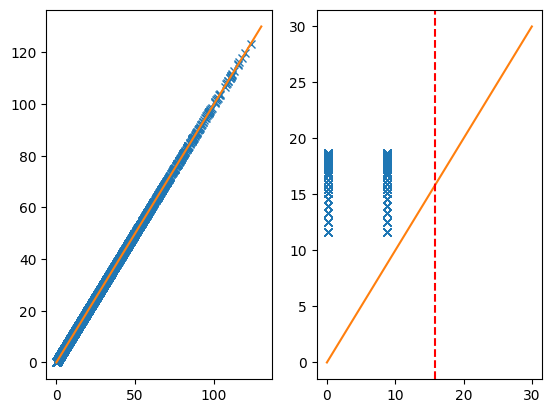

220.40296865921061
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.632  0.362E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     2  -1.279  0.367E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     3  -1.531  0.357E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     4  -1.705  0.278E+00    32008    39.74  0.155   [Radiance 0.660 micron]
     5  -2.006  0.178E+00    32194    40.99  0.160   [Radiance 0.660 micron]
     6  -2.074  0.112E+00    32907    45.32  0.177   [Radiance 0.660 micron]
     7  -2.120  0.839E-01    33733    49.90  0.195   [Radiance 0.660 micron]
     8  -2.268  0.698E-01    34525    53.97  0.211   [Radiance 0.660 micron]
     9  -2.336  0.564E-01    36003    61.22  0.239   [Radiance 0.660 micron]
    10  -2.396  0.480E-01    37499    68.20  0.266   [Radiance 0.660 micron]
    11  -2.480  0.421E-01    39049    74.95  0.293   [Radiance 0.660 micron]
    12  -2.529  0.368E-01    40988    82.69  0.323   [Radian

<Figure size 640x480 with 0 Axes>

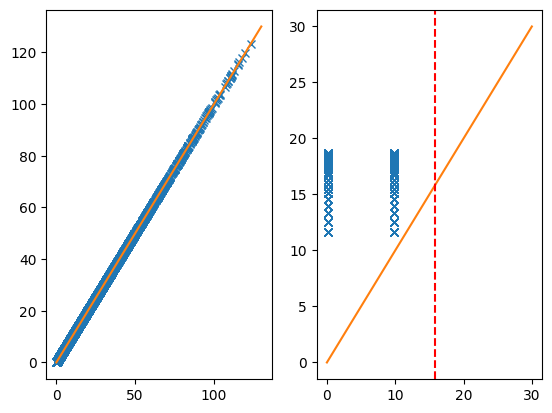

145.25578590399954
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.632  0.358E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     2  -1.279  0.363E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     3  -1.532  0.354E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     4  -1.707  0.275E+00    32008    39.74  0.155   [Radiance 0.660 micron]
     5  -2.009  0.177E+00    32190    40.96  0.160   [Radiance 0.660 micron]
     6  -2.078  0.111E+00    32898    45.27  0.177   [Radiance 0.660 micron]
     7  -2.124  0.832E-01    33717    49.83  0.195   [Radiance 0.660 micron]
     8  -2.275  0.692E-01    34500    53.87  0.210   [Radiance 0.660 micron]
     9  -2.341  0.558E-01    35995    61.18  0.239   [Radiance 0.660 micron]
    10  -2.402  0.475E-01    37476    68.14  0.266   [Radiance 0.660 micron]
    11  -2.485  0.417E-01    39030    74.91  0.293   [Radiance 0.660 micron]
    12  -2.532  0.365E-01    40935    82.50  0.322   [Radian

<Figure size 640x480 with 0 Axes>

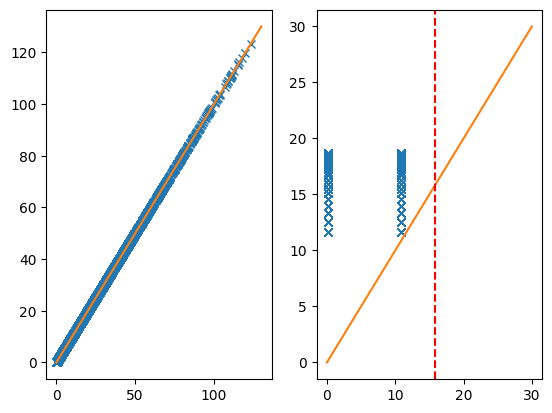

95.85547314478904
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.632  0.355E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     2  -1.278  0.360E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     3  -1.533  0.351E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     4  -1.708  0.273E+00    32008    39.74  0.155   [Radiance 0.660 micron]
     5  -2.011  0.176E+00    32190    40.96  0.160   [Radiance 0.660 micron]
     6  -2.082  0.110E+00    32879    45.16  0.176   [Radiance 0.660 micron]
     7  -2.127  0.825E-01    33709    49.79  0.194   [Radiance 0.660 micron]
     8  -2.281  0.687E-01    34482    53.80  0.210   [Radiance 0.660 micron]
     9  -2.342  0.553E-01    36001    61.20  0.239   [Radiance 0.660 micron]
    10  -2.410  0.472E-01    37435    67.94  0.265   [Radiance 0.660 micron]
    11  -2.490  0.413E-01    39016    74.86  0.292   [Radiance 0.660 micron]
    12  -2.538  0.362E-01    40853    82.22  0.321   [Radianc

<Figure size 640x480 with 0 Axes>

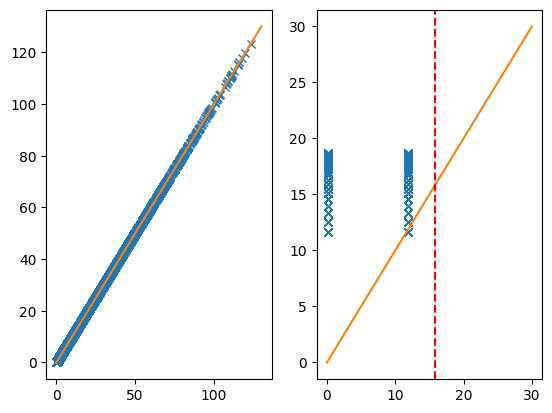

59.37747326644198
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.632  0.353E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     2  -1.278  0.358E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     3  -1.533  0.348E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     4  -1.709  0.271E+00    32008    39.74  0.155   [Radiance 0.660 micron]
     5  -2.013  0.174E+00    32190    40.96  0.160   [Radiance 0.660 micron]
     6  -2.084  0.110E+00    32878    45.16  0.176   [Radiance 0.660 micron]
     7  -2.129  0.820E-01    33702    49.76  0.194   [Radiance 0.660 micron]
     8  -2.285  0.683E-01    34473    53.76  0.210   [Radiance 0.660 micron]
     9  -2.347  0.549E-01    35977    61.10  0.239   [Radiance 0.660 micron]
    10  -2.412  0.469E-01    37430    67.92  0.265   [Radiance 0.660 micron]
    11  -2.495  0.410E-01    38981    74.74  0.292   [Radiance 0.660 micron]
    12  -2.544  0.359E-01    40805    82.04  0.320   [Radianc

<Figure size 640x480 with 0 Axes>

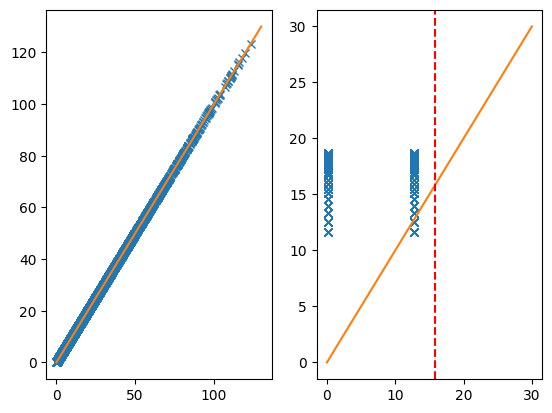

39.1960348280758
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.632  0.351E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     2  -1.278  0.355E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     3  -1.534  0.346E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     4  -1.710  0.270E+00    32008    39.74  0.155   [Radiance 0.660 micron]
     5  -2.015  0.173E+00    32190    40.96  0.160   [Radiance 0.660 micron]
     6  -2.086  0.109E+00    32872    45.12  0.176   [Radiance 0.660 micron]
     7  -2.133  0.816E-01    33699    49.75  0.194   [Radiance 0.660 micron]
     8  -2.286  0.679E-01    34467    53.73  0.210   [Radiance 0.660 micron]
     9  -2.354  0.547E-01    35943    60.96  0.238   [Radiance 0.660 micron]
    10  -2.415  0.465E-01    37432    67.94  0.265   [Radiance 0.660 micron]
    11  -2.500  0.408E-01    38969    74.72  0.292   [Radiance 0.660 micron]
    12  -2.545  0.356E-01    40813    82.08  0.321   [Radiance

<Figure size 640x480 with 0 Axes>

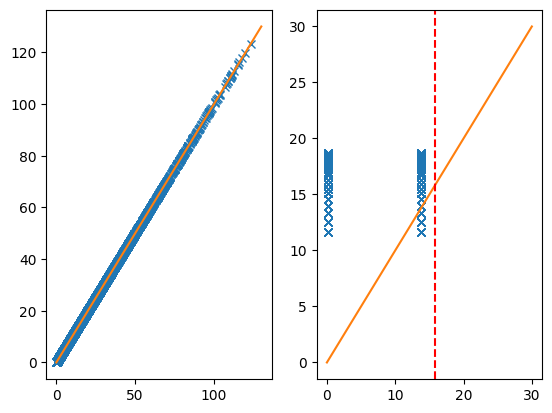

21.047771062852053
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.631  0.349E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     2  -1.278  0.353E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     3  -1.534  0.344E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     4  -1.711  0.268E+00    32008    39.74  0.155   [Radiance 0.660 micron]
     5  -2.017  0.172E+00    32190    40.96  0.160   [Radiance 0.660 micron]
     6  -2.089  0.109E+00    32865    45.07  0.176   [Radiance 0.660 micron]
     7  -2.135  0.812E-01    33683    49.66  0.194   [Radiance 0.660 micron]
     8  -2.289  0.675E-01    34466    53.73  0.210   [Radiance 0.660 micron]
     9  -2.357  0.544E-01    35924    60.89  0.238   [Radiance 0.660 micron]
    10  -2.418  0.462E-01    37432    67.94  0.265   [Radiance 0.660 micron]
    11  -2.504  0.405E-01    38950    74.65  0.292   [Radiance 0.660 micron]
    12  -2.549  0.354E-01    40800    82.05  0.320   [Radian

<Figure size 640x480 with 0 Axes>

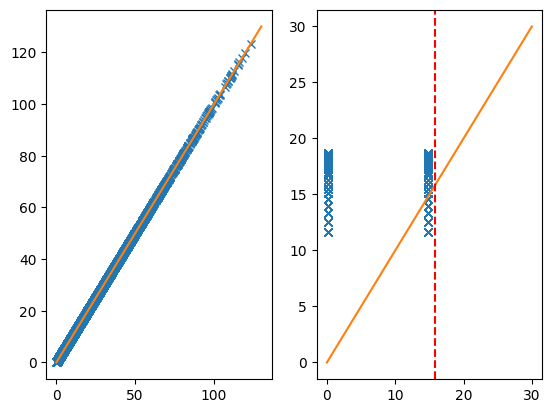

10.75523233411706
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.631  0.348E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     2  -1.277  0.352E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     3  -1.535  0.342E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     4  -1.712  0.267E+00    32008    39.74  0.155   [Radiance 0.660 micron]
     5  -2.018  0.173E+00    32189    40.95  0.160   [Radiance 0.660 micron]
     6  -2.091  0.108E+00    32861    45.05  0.176   [Radiance 0.660 micron]
     7  -2.136  0.809E-01    33676    49.63  0.194   [Radiance 0.660 micron]
     8  -2.291  0.673E-01    34454    53.67  0.210   [Radiance 0.660 micron]
     9  -2.360  0.542E-01    35909    60.82  0.238   [Radiance 0.660 micron]
    10  -2.421  0.460E-01    37418    67.88  0.265   [Radiance 0.660 micron]
    11  -2.507  0.403E-01    38935    74.58  0.291   [Radiance 0.660 micron]
    12  -2.550  0.352E-01    40804    82.06  0.321   [Radianc

<Figure size 640x480 with 0 Axes>

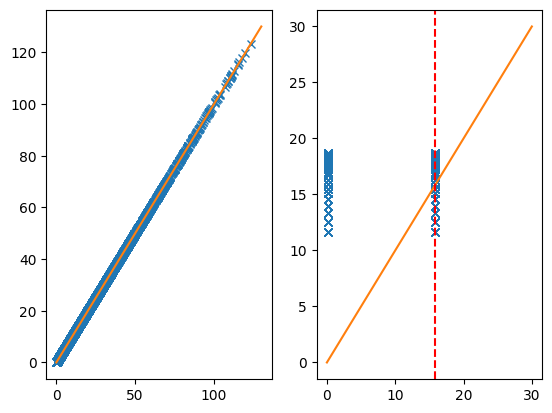

5.255830174815887
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.631  0.346E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     2  -1.277  0.350E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     3  -1.535  0.340E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     4  -1.712  0.266E+00    32008    39.74  0.155   [Radiance 0.660 micron]
     5  -2.020  0.172E+00    32185    40.93  0.160   [Radiance 0.660 micron]
     6  -2.093  0.108E+00    32851    45.00  0.176   [Radiance 0.660 micron]
     7  -2.138  0.805E-01    33674    49.61  0.194   [Radiance 0.660 micron]
     8  -2.293  0.670E-01    34453    53.67  0.210   [Radiance 0.660 micron]
     9  -2.363  0.540E-01    35908    60.81  0.238   [Radiance 0.660 micron]
    10  -2.424  0.458E-01    37393    67.80  0.265   [Radiance 0.660 micron]
    11  -2.508  0.401E-01    38931    74.57  0.291   [Radiance 0.660 micron]
    12  -2.558  0.351E-01    40778    81.97  0.320   [Radianc

<Figure size 640x480 with 0 Axes>

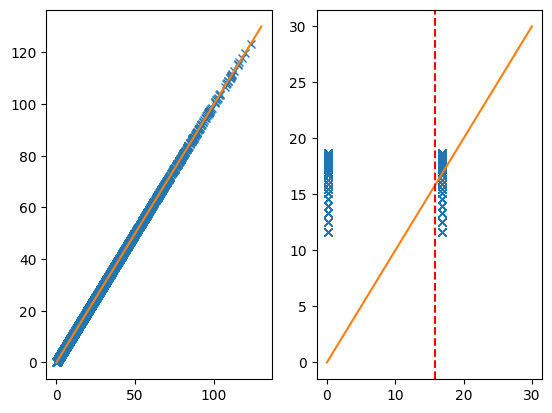

2.916915543311052
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.631  0.345E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     2  -1.277  0.349E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     3  -1.535  0.339E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     4  -1.713  0.265E+00    32008    39.74  0.155   [Radiance 0.660 micron]
     5  -2.021  0.172E+00    32185    40.93  0.160   [Radiance 0.660 micron]
     6  -2.095  0.107E+00    32847    44.97  0.176   [Radiance 0.660 micron]
     7  -2.140  0.802E-01    33670    49.60  0.194   [Radiance 0.660 micron]
     8  -2.296  0.668E-01    34442    53.63  0.209   [Radiance 0.660 micron]
     9  -2.363  0.537E-01    35910    60.83  0.238   [Radiance 0.660 micron]
    10  -2.427  0.457E-01    37392    67.80  0.265   [Radiance 0.660 micron]
    11  -2.511  0.400E-01    38932    74.59  0.291   [Radiance 0.660 micron]
    12  -2.559  0.350E-01    40780    81.98  0.320   [Radianc

<Figure size 640x480 with 0 Axes>

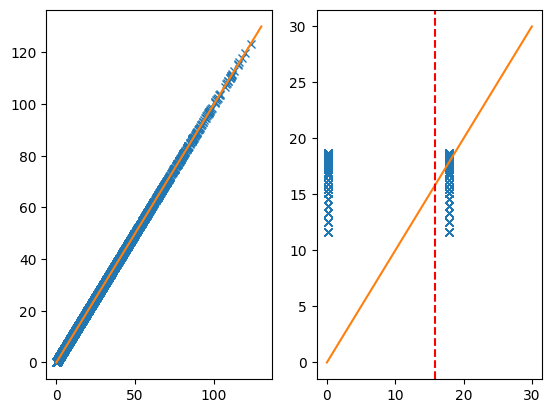

2.957680365106504
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.631  0.344E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     2  -1.277  0.348E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     3  -1.535  0.338E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     4  -1.713  0.264E+00    32008    39.74  0.155   [Radiance 0.660 micron]
     5  -2.022  0.171E+00    32185    40.93  0.160   [Radiance 0.660 micron]
     6  -2.096  0.107E+00    32847    44.97  0.176   [Radiance 0.660 micron]
     7  -2.141  0.800E-01    33667    49.58  0.194   [Radiance 0.660 micron]
     8  -2.297  0.666E-01    34438    53.60  0.209   [Radiance 0.660 micron]
     9  -2.366  0.536E-01    35903    60.82  0.238   [Radiance 0.660 micron]
    10  -2.428  0.455E-01    37394    67.81  0.265   [Radiance 0.660 micron]
    11  -2.514  0.399E-01    38900    74.45  0.291   [Radiance 0.660 micron]
    12  -2.559  0.349E-01    40771    81.97  0.320   [Radianc

<Figure size 640x480 with 0 Axes>

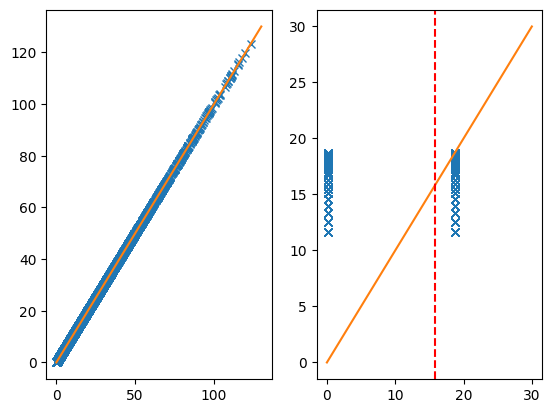

4.818167386064625
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.631  0.343E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     2  -1.277  0.346E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     3  -1.536  0.337E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     4  -1.714  0.263E+00    32008    39.74  0.155   [Radiance 0.660 micron]
     5  -2.023  0.171E+00    32185    40.93  0.160   [Radiance 0.660 micron]
     6  -2.097  0.107E+00    32843    44.95  0.176   [Radiance 0.660 micron]
     7  -2.142  0.796E-01    33668    49.58  0.194   [Radiance 0.660 micron]
     8  -2.300  0.664E-01    34435    53.59  0.209   [Radiance 0.660 micron]
     9  -2.366  0.534E-01    35907    60.85  0.238   [Radiance 0.660 micron]
    10  -2.431  0.454E-01    37378    67.73  0.265   [Radiance 0.660 micron]
    11  -2.516  0.397E-01    38902    74.48  0.291   [Radiance 0.660 micron]
    12  -2.561  0.347E-01    40766    81.97  0.320   [Radianc

<Figure size 640x480 with 0 Axes>

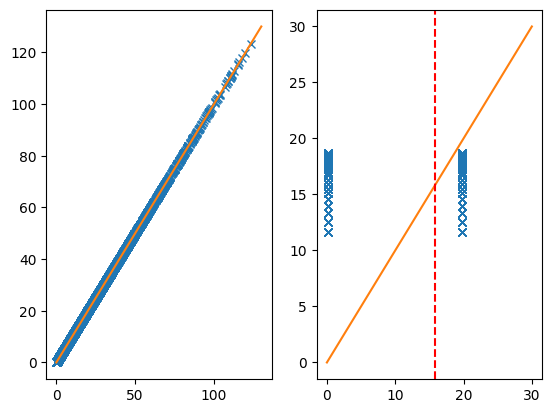

7.902069999707205
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.631  0.342E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     2  -1.277  0.345E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     3  -1.536  0.336E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     4  -1.714  0.265E+00    32005    39.72  0.155   [Radiance 0.660 micron]
     5  -2.025  0.171E+00    32184    40.92  0.160   [Radiance 0.660 micron]
     6  -2.098  0.107E+00    32843    44.95  0.176   [Radiance 0.660 micron]
     7  -2.142  0.794E-01    33668    49.58  0.194   [Radiance 0.660 micron]
     8  -2.303  0.663E-01    34420    53.52  0.209   [Radiance 0.660 micron]
     9  -2.367  0.532E-01    35908    60.85  0.238   [Radiance 0.660 micron]
    10  -2.433  0.453E-01    37364    67.68  0.264   [Radiance 0.660 micron]
    11  -2.521  0.396E-01    38896    74.45  0.291   [Radiance 0.660 micron]
    12  -2.563  0.345E-01    40794    82.08  0.321   [Radianc

<Figure size 640x480 with 0 Axes>

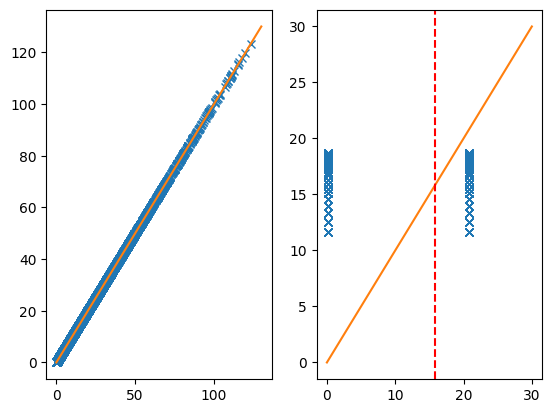

12.079971916110667
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.631  0.341E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     2  -1.276  0.345E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     3  -1.536  0.335E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     4  -1.714  0.264E+00    32005    39.72  0.155   [Radiance 0.660 micron]
     5  -2.025  0.170E+00    32184    40.92  0.160   [Radiance 0.660 micron]
     6  -2.097  0.106E+00    32845    44.96  0.176   [Radiance 0.660 micron]
     7  -2.144  0.794E-01    33661    49.56  0.194   [Radiance 0.660 micron]
     8  -2.304  0.661E-01    34420    53.52  0.209   [Radiance 0.660 micron]
     9  -2.368  0.531E-01    35899    60.81  0.238   [Radiance 0.660 micron]
    10  -2.433  0.452E-01    37368    67.70  0.264   [Radiance 0.660 micron]
    11  -2.523  0.396E-01    38882    74.40  0.291   [Radiance 0.660 micron]
    12  -2.558  0.344E-01    40791    82.07  0.321   [Radian

<Figure size 640x480 with 0 Axes>

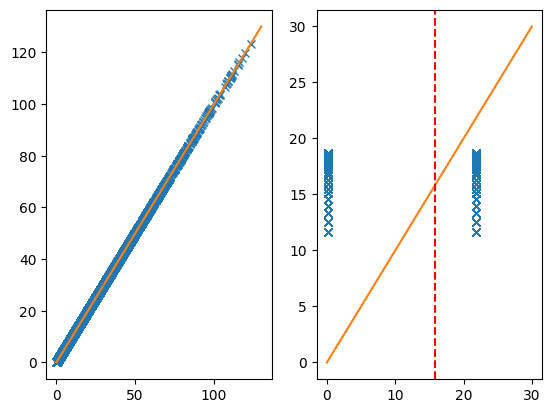

17.193015197624405
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.631  0.340E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     2  -1.276  0.344E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     3  -1.536  0.334E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     4  -1.715  0.263E+00    32005    39.72  0.155   [Radiance 0.660 micron]
     5  -2.026  0.170E+00    32184    40.92  0.160   [Radiance 0.660 micron]
     6  -2.098  0.106E+00    32845    44.96  0.176   [Radiance 0.660 micron]
     7  -2.145  0.793E-01    33656    49.53  0.193   [Radiance 0.660 micron]
     8  -2.307  0.660E-01    34415    53.49  0.209   [Radiance 0.660 micron]
     9  -2.370  0.529E-01    35906    60.85  0.238   [Radiance 0.660 micron]
    10  -2.433  0.450E-01    37367    67.70  0.264   [Radiance 0.660 micron]
    11  -2.525  0.394E-01    38881    74.39  0.291   [Radiance 0.660 micron]
    12  -2.560  0.344E-01    40793    82.08  0.321   [Radian

<Figure size 640x480 with 0 Axes>

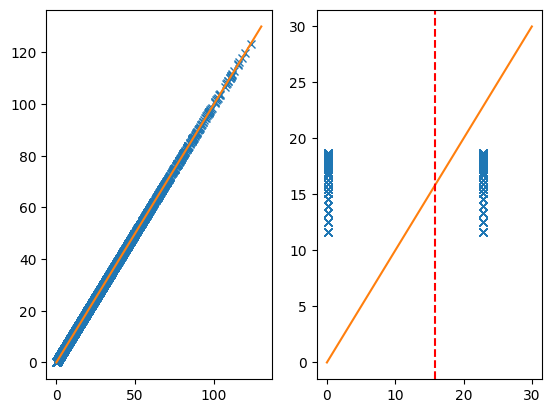

22.458659583964966
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.631  0.339E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     2  -1.276  0.343E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     3  -1.536  0.333E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     4  -1.715  0.263E+00    32005    39.72  0.155   [Radiance 0.660 micron]
     5  -2.027  0.169E+00    32188    40.95  0.160   [Radiance 0.660 micron]
     6  -2.099  0.106E+00    32845    44.96  0.176   [Radiance 0.660 micron]
     7  -2.148  0.791E-01    33656    49.53  0.193   [Radiance 0.660 micron]
     8  -2.307  0.658E-01    34422    53.53  0.209   [Radiance 0.660 micron]
     9  -2.371  0.528E-01    35903    60.83  0.238   [Radiance 0.660 micron]
    10  -2.435  0.449E-01    37364    67.68  0.264   [Radiance 0.660 micron]
    11  -2.527  0.394E-01    38876    74.37  0.291   [Radiance 0.660 micron]
    12  -2.562  0.343E-01    40792    82.07  0.321   [Radian

<Figure size 640x480 with 0 Axes>

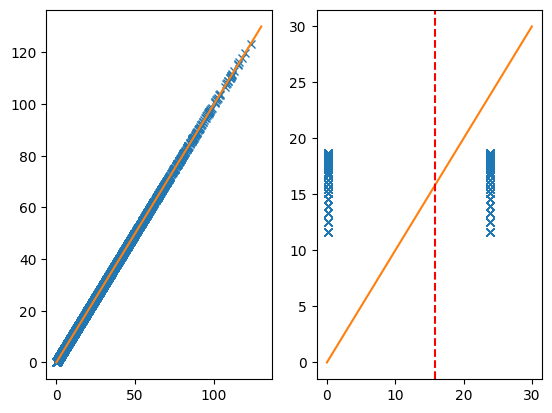

28.203025837690994
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.631  0.339E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     2  -1.276  0.342E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     3  -1.536  0.332E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     4  -1.715  0.262E+00    32005    39.72  0.155   [Radiance 0.660 micron]
     5  -2.027  0.169E+00    32188    40.95  0.160   [Radiance 0.660 micron]
     6  -2.099  0.105E+00    32847    44.97  0.176   [Radiance 0.660 micron]
     7  -2.149  0.791E-01    33653    49.51  0.193   [Radiance 0.660 micron]
     8  -2.309  0.656E-01    34422    53.53  0.209   [Radiance 0.660 micron]
     9  -2.372  0.527E-01    35904    60.84  0.238   [Radiance 0.660 micron]
    10  -2.436  0.448E-01    37362    67.67  0.264   [Radiance 0.660 micron]
    11  -2.529  0.393E-01    38869    74.34  0.290   [Radiance 0.660 micron]
    12  -2.563  0.342E-01    40797    82.10  0.321   [Radian

<Figure size 640x480 with 0 Axes>

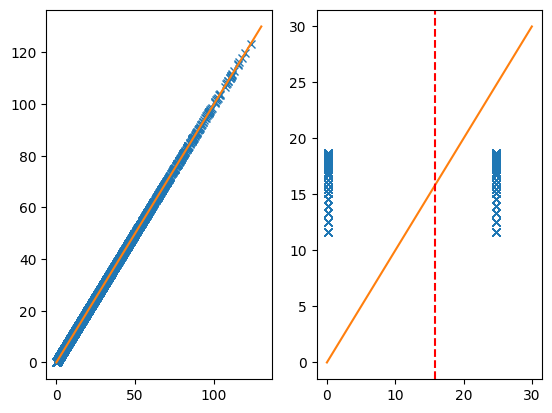

34.13979729202537


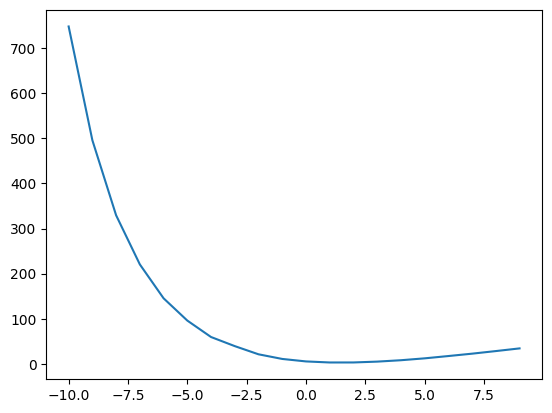

In [8]:
solvers_reconstruct = at3d.containers.SolversDict()

# We are using the ground_truth rte_grid.
grid_to_optical_properties = at3d.medium.MicrophysicsGridToOpticalProperties(
    rte_grid, optical_property_generator, optical_properties
)
def get_loss(reff_diff):
    # UnknownScatterers is a container for all of the unknown variables.
    # Each unknown_scatterer also records the transforms from the abstract state vector
    # to the gridded data in physical coordinates.
    unknown_scatterers = at3d.containers.UnknownScatterers(
        at3d.medium.UnknownScatterer(grid_to_optical_properties,
        density=(None, at3d.transforms.StateToGridMask(mask=carved_volume.mask.data)),
        reff=(None, at3d.transforms.StateToGridUniform(mask=carved_volume.mask.data)))
    )
    # now we form state_gen which updates the solvers with an input_state.

    state_gen = at3d.medium.StateGenerator(solvers_reconstruct,
                                            unknown_scatterers, surfaces,
                                            numerical_parameters, sources, background_optical_scatterers,
                                            num_stokes)
    # get bounds automatically.
    min_bounds, max_bounds = state_gen.transform_bounds()
    # transform initial physical state to abstract state. 
    initial_gridded_extinction = 3.0*solvers[0.66].medium['cloud'].density.data/(2.0*997.0* solvers[0.66].medium['cloud'].reff.data*1e-6)
    initial_1d_extinction = state_gen._unknown_scatterers['cloud'].variables['density'].state_to_grid.inverse_transform(initial_gridded_extinction)
    initial_gridded_reff = solvers[0.66].medium['cloud'].reff.data * 0 + solvers[0.66].medium['cloud'].reff.data.mean() + reff_diff
    initial_1d_reff = state_gen._unknown_scatterers['cloud'].variables['reff'].state_to_grid.inverse_transform(initial_gridded_reff)
    x0 = np.concatenate((state_gen._unknown_scatterers['cloud'].variables['density'].coordinate_transform.inverse_transform(initial_1d_extinction),
                state_gen._unknown_scatterers['cloud'].variables['reff'].coordinate_transform.inverse_transform(initial_1d_reff)))
    objective_function = at3d.optimize.ObjectiveFunction.LevisApproxUncorrelatedL2(
        sensors, solvers_reconstruct, forward_sensors, unknown_scatterers, state_gen,
        state_gen.project_gradient_to_state,
            parallel_solve_kwargs={'n_jobs': 4, 'verbose': True},
        gradient_kwargs={'cost_function': 'L2', 'exact_single_scatter':True},
        uncertainty_kwargs={'add_noise': False},
        min_bounds=min_bounds, max_bounds=max_bounds)
    # solvers_reconstruct[0.66].medium['cloud'].reff.data = solvers[0.66].medium['cloud'].reff.data + reff_diff
    return objective_function(x0)[0]
losses = []
for i in range(-10, 10):
    losses.append(get_loss(i))
    plot(None)
    print(losses[i+10])
py.plot(range(-10, 10),losses)


In [1]:
py.plot(range(-3, 10), np.array(losses)[7:])
py.xlabel("Uniform Reff Difference From Ground Truth (um)")
py.ylabel("Loss")
py.title("Loss vs Reff Using Ground Truth Geometric Extinction")

NameError: name 'py' is not defined